# Bandit Algorithms

In [8]:
from random import uniform
import os
import sys

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# pip install ../

NameError: name '__file__' is not defined

In [4]:
# Some standard imports
import numpy as np
from scipy.stats import bernoulli
from math import log
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-v0_8')

In [7]:
from bandit_practice.model import Environment, Agent, MAB_env
import bandit_practice.model
from bandit_practice.display import plot_result
import bandit_practice.bandit_solutions as solutions

ModuleNotFoundError: No module named 'bandit_practice'

# Part 1 &mdash; Multi-Armed Bandits

We formulate the choice design of a webpage design as a multi-armed bandit problem.  We
will use the synthetically generated “visits” of users, for each user the system will recommend the version of the website, so each version of the website is an arm. We model the engagement score (~#clicks) corresponding to the of version of the website as a Gaussian random variable.

## Interaction protocol
 An (adaptive) agent interacts with an unknown environment for $T$ rounds. At each round $t$:

* The agent picks an arm (action) $A_t$ from a set of $K$ actions
* The agent receives a reward $R_t \sim \nu_{A_t}$

where $\nu_{a}$ is an *unknown* distribution with mean $\mu_a$. In our case, it's a Gaussian distribution *with standard deviation $\sigma=1$ for all arms*:

$R_t \sim N(\mu_{A_t}; 1)$

The goal is to maximize total reward $\sum_{t=1}^TR_t$.

Here is some code to play a bandit algorithm (adaptive agent) in a MAB environment, and to compare the performance on different algorithms on the same problem.

In [109]:
def play_mab(environment, agent, N, T):
    """
    Play N independent runs of length T for the specified agent.

    :param environment: a MAB instance
    :param agent: a bandit algorithm
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the agent's name, and the collected data in numpy arrays
    """

    rewards = np.zeros((N, T))
    regrets = np.zeros((N, T))
    pseudo_regrets = np.zeros((N, T))
    avg_rewards = np.zeros((N, T))

    for n in range(N):
        agent.reset()
        for t in range(T):
            action = agent.get_action()
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instantaneous reward  and (pseudo) regret
            rewards[n,t] = reward
            means = environment.get_means()
            best_reward = np.max(means)
            regrets[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive
            avg_rewards[n,t] = means[action]
            pseudo_regrets[n,t] = best_reward - means[action]

    return agent.name(), rewards, regrets, avg_rewards, pseudo_regrets


def experiment_mab(environment, agents, N, T, mode="regret"):
    """
    Play N trajectories for all agents over a horizon T. Store data in a dictionary.

    :param environment: a MAB instance
    :param agent: a list of bandit algorithms to compare
    :param N: number of independent simulations
    :param T: decision horizon
    :param mode: the performance measure to return ("reward", "average reward", "regret", "pseudo regret")
    :return: the performance for each agent in a dictionary indexed by the agent's name
    """

    all_data = {}

    for agent in agents:
        agent_id, rewards, regrets, avg_rewards, pseudo_regrets = play_mab(environment, agent, N, T)

        if mode == "regret":
            all_data[agent_id] = regrets
        elif mode == "pseudo regret":
            all_data[agent_id] = pseudo_regrets
        elif mode == "reward":
            all_data[agent_id] = rewards
        elif mode == "average reward":
            all_data[agent_id] = avg_rewards
        else:
            raise ValueError

    return all_data

Our MAB environment has 3 arms (three possible website designs). We will run online algorithms for $T=1000$ steps (corresponding to 1000 users visiting the website in sequence) and average results over $N=50$ independent runs.

In [110]:
K = 3  # number of arms (website versions)

env = MAB_env(solutions.MEANS) #We don't know the reward distributions in advance!

T = 1000  # Horizon
N = 50  # number of simulations

# Visualization
Nsub = 100 # Subsampled points
tsav = range(2, T, Nsub)

## Exercise 1.A &mdash; (Epsilon) Greedy
**tl;dr**
> $A_t = \arg\max_{a\in\{1,\dots,K\}} \widehat{\mu}_a(t-1)$ with probability $1-\epsilon$
>
> $A_t \sim \mathrm{Uniform}(1,\dots,K)$ otherwise

Let's start with the $\epsilon$-greedy algorithm, where $\epsilon$ is an "exploration" parameter.

* $A_t = \arg\max_{a\in\{1,\dots,K\}} \widehat{\mu}_a(t-1)$ with probability $1-\epsilon$

* $A_t \sim \mathrm{Uniform}(1,\dots,K)$ otherwise

Where $\widehat{\mu}_a(t-1)$ is the average reward for arm $a$ up to time $t-1$ included.

You are given an *incomplete* implementation of $\epsilon$-greedy that actually implements the Greedy algorithm ($\epsilon=0$). This code already includes computation of average rewards!

In [111]:
class EpsilonGreedy(Agent):
  """
  Epsilon-Greedy MAB algorithm

  :param K: number of arms
  :param eps: exploration probability
  """
  def __init__(self, K, eps=0.):
    self.eps = eps
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE:
    #Change this value to true for changing epsilon implementation
    changing_epsilons = False

    probability = np.random.random()



    if changing_epsilons:
        delta = np.max(self.avg_rewards) - np.min(self.avg_rewards)
        eps_t = self.eps
        if delta > 0 and self.t > 0:
            d = delta/2
            eps_t = min(1, self.K / (d**2 * self.t)) # we take c=1
        if probability < eps_t:
            return np.random.randint(0, self.K)
    # END OF YOUR CODE
    else:
        if probability < self.eps:
            return np.random.randint(0, self.K)

    chosen_arm_index = np.argmax(self.avg_rewards)
    return chosen_arm_index


  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm] # update

    self.t += 1

  def name(self):
    return 'EGreedy('+str(self.eps)+')'

First let's see how we can visualize the result of an algorithm, using Greedy as an example

In [112]:
greedy = EpsilonGreedy(K,  eps=0.)

What we can measure **in a real bandit application** is just the rewards of the selected arms! This is the nature of bandit feedback.

Results are averaged over the N runs. In a real online application, there is *only one run!*

The `q` parameter of `plot_result` specifies the quantile of the error bars (shaded area)

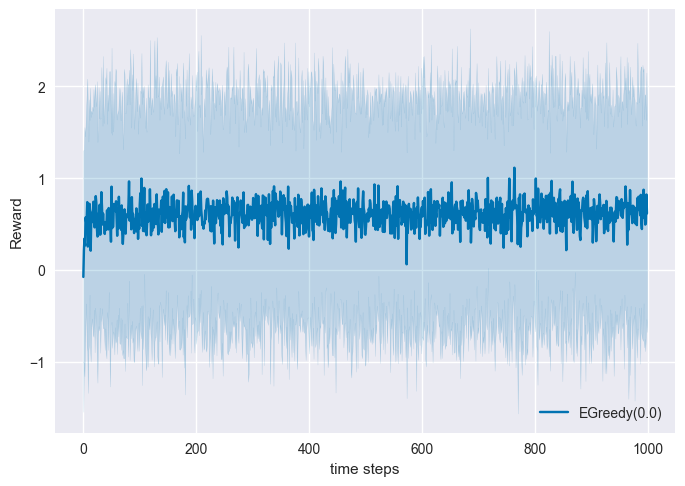

In [113]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")

plot_result(greedy_experiment, q=10, mode="reward", cumulative=False);

For better visualization, we can also sum rewards over time

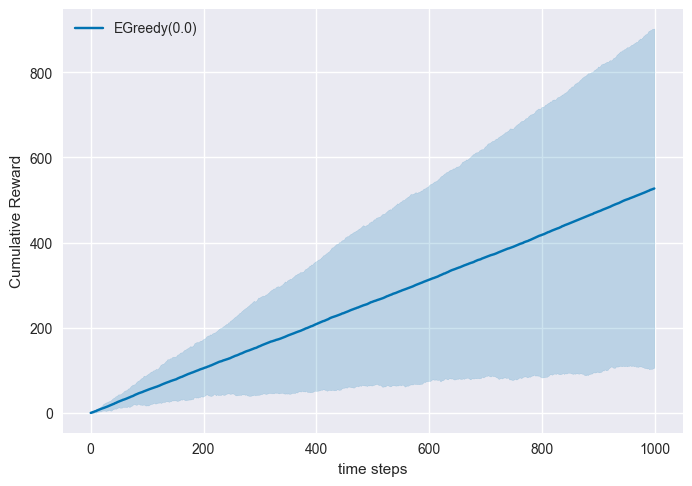

In [114]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="reward")
plot_result(greedy_experiment, q=10, mode="reward", cumulative=True);

In research experiments, we often test algorithms on known distribution. This allows us to compute the (cumulative) regret:

$\mathrm{Regret}(T) = T\mu_\star - \sum_{t=1}^TR_t$

Of course the agent doesn't have acces to this information, neither would we in a real application.

Remember that **smaller regret is always better** when comparing algorithms.

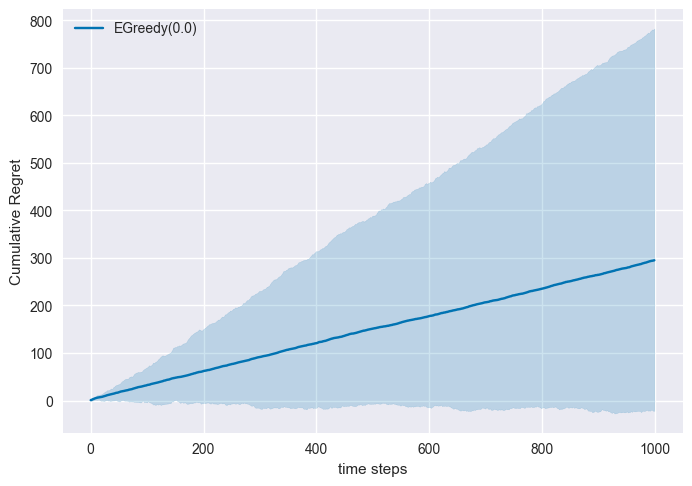

In [115]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="regret")
plot_result(greedy_experiment, q=10, mode="regret");

Finally, we can ignore the noise in the rewards and compute the **pseudo regret** instead (again, only in a controlled experiment):

$\widetilde{\mathrm{Regret}}(T) = T\mu_\star - \sum_{t=1}^T\mu_{A_t}$

We will use pseudo regret going on.

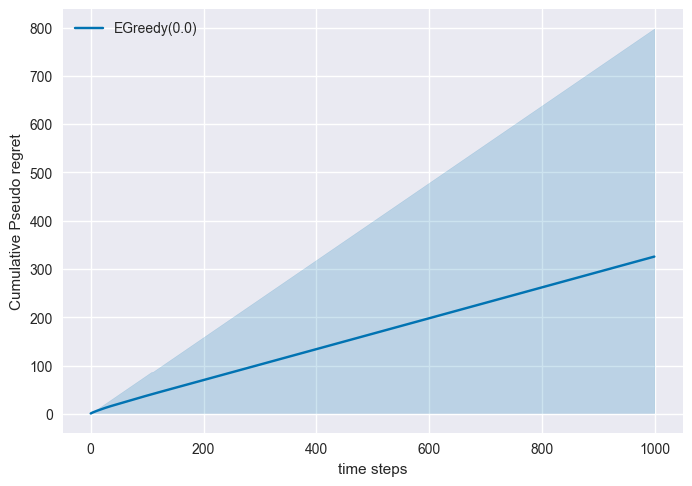

In [116]:
greedy_experiment = experiment_mab(env, [greedy], N=N, T=T, mode="pseudo regret")
plot_result(greedy_experiment, q=10, mode="pseudo regret");

Now it's time to test you implementation of epsilon greedy:

In [117]:
# eps_greedy = EpsilonGreedy(K,  eps=0.1) # Pick your epsilon!
#
# epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]  # Different exploration rates
# eps_greedy_tests = []
# for eps in epsilons:
#     eps_greedy_tests.append(EpsilonGreedy(K, eps=eps))
#
# # epsilons_2 = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
# # eps_greedy_tests_2 = []
# #
# # for eps in epsilons_2:
# #     eps_greedy_tests_2.append(EpsilonGreedy(K, eps=eps))
#
#
# eps_greedy_experiment = experiment_mab(env, [eps_greedy, greedy], N=N, T=T, mode="pseudo regret")
# plot_result(eps_greedy_experiment, q=10, mode="pseudo regret")
#
# eps_greedy_experiment_optimal = experiment_mab(env, eps_greedy_tests, N=N, T=T, mode="pseudo regret")
# plot_result(eps_greedy_experiment_optimal, q=10, mode="pseudo regret")
#
# # eps_greedy_experiment_optimal_2 = experiment_mab(env, eps_greedy_tests_2, N=1000, T=T, mode="pseudo regret")
# # plot_result(eps_greedy_experiment_optimal_2, q=10, mode="pseudo regret")
#
#
# eps_greedy_regret = eps_greedy_experiment['EGreedy(0.1)']
# cumdata = np.cumsum(eps_greedy_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# print(f"Cumulative regret for epsilon - 0.1: {mean_reg}")

## Exercise 1.B &mdash; UCB

**tl;dr**
> $A_t = \arg\max_{a\in\{1,\dots,K\}} \left\{\widehat{\mu}_a(t) + \sqrt{\frac{\alpha \log t}{N_a(t)}}\right\}$


**After playing each arm once, do:**

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

where the score or *index* of an action is

$F_t(a) = \widehat{\mu}_a(t) + \sqrt{\frac{\alpha \log t}{N_a(t)}}$               

and $N_a(t)$ is the number of times arm $a$ was selected up to time $t$ and $\alpha>0$ is an exploration parameter. In the following code, only the action selection part is missing

In [118]:
class UCB(Agent):
  """
  UCB (Upper Confidence Bound) MAB algorithm

  :param K: number of arms
  :param alpha: scaling of the optimistic bonus (appears under square root)
  """
  def __init__(self, K, alpha):
    self.alpha = alpha
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)


  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE

    scores = np.zeros(self.K) # K-dimensional ndarray

    for a in range(0,self.K):
        #avoid division by zero by dividing by small value if numplayed is 0
        if self.num_played[a] == 0:
            scores[a] = self.avg_rewards[a] + np.sqrt((self.alpha * np.log(self.t +1 )) / 1e-10)
        else:
            # To avoid negative log value, always take atleast log 1
            scores[a] = self.avg_rewards[a] + np.sqrt((self.alpha * np.log(self.t + 1)) / (self.num_played[a]))
    # END OF YOUR CODE

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'UCB('+str(self.alpha)+')'

In [119]:
# ucb = UCB(K, alpha=0.1) # Pick your alpha!
#
# epsilon_greedy = solutions.EpsilonGreedy(K,  eps=solutions.EPSILON)
# ucb_experiment = experiment_mab(env, [ucb, epsilon_greedy], N=500, T=T, mode="pseudo regret")
# plot_result(ucb_experiment, q=10, mode="pseudo regret")
#
# ucb_regret = ucb_experiment['UCB(0.1)']
# cumdata = np.cumsum(ucb_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# print(f"Cumulative regret for alpha - 0.1: {mean_reg}")
#
# alphas = [0.5, 1.0, 1.25, 1.5, 2.0, 5]
# ucb_tests = []
#
# for alpha in alphas:
#     ucb_tests.append(UCB(K, alpha=alpha))
#
# ucb_experiment_2 = experiment_mab(env, ucb_tests, N=N, T=T, mode="pseudo regret")
#
# # Plot results
# plot_result(ucb_experiment, q=10, mode="pseudo regret")
# plot_result(ucb_experiment_2, q=10, mode="pseudo regret")
#


## Exercise 1.C &mdash; Thompson Sampling

**tl;dr**
> $F_{t-1,a} \sim N\left(\widehat{\mu}_a(t-1); \frac{\sigma^2}{N_a(t-1)}\right)$
>
> $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$


### 📖 Gaussian Thompson Sampling

TS is a *randomized* algorithm. We can still write the selection rule as for index algorithms:

$A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

but now $F_{t}(a)$ is a randomized quantity:

$F_{t}(a) \sim Q_{t,a}$

where $Q_{t,a}$ is a *posterior distribution* obtained by Bayes' rule:

$Q_{t,a}(F) \propto Q_{t-1,a}(F) \cdot P(R_t | F)$

starting from some given *prior* $Q_{0,a}$ and sequentially updating it (only for the chosen arm) with the *likelihood* of observed rewards (separately for each arm)

In our case *we know* the rewards are gaussian with standard deviation $\sigma=1$, so it is natural to use a Gaussian likelihood:

$P(R_t|\mu_a=F) = N(F;1)$

and a zero-mean Gaussian prior:

$Q_{0,a} = N(0;1)$ for all $a$.

By Bayes' rule it's easy to show that the posterior is also Gaussian

$Q_{t,a} = N\left(\widehat{\mu}_a(t-1); \frac{\sigma^2}{N_a(t-1)}\right)$

where $\sigma=1$ in our case. So you can implement the selection rule of Gaussian TS as follows:

* For each arm $a\in\{1,\dots,K\}$ sample $F_{t-1,a} \sim N\left(\widehat{\mu}_a(t-1); \frac{\sigma^2}{N_a(t-1)}\right)$
* Play $A_t = \arg\max_{a\in\{1,\dots,K\}} F_{t-1}(a)$

🎁 [Hint](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)

In [120]:
class ThompsonSampling(Agent):
  """
  Thompson Sampling MAB algorithm for Gaussian rewards

  :param K: number of arms
  :param sigma: standard deviation of Gaussian prior
  """
  def __init__(self, K, sigma=1.):
    self.sigma = sigma
    self.K = K
    self.reset()

    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)
    self.avg_rewards = np.zeros(self.K)


  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.avg_rewards = np.zeros(self.K)
    self.cumulative_reward = np.zeros(self.K)
    self.num_played = np.zeros(self.K)

  def get_action(self):
    """
    Select the arm to play based on current history

    :return: the selected arm (an integer between 0 and K-1)
    """
    # YOUR CODE HERE

    scores = np.zeros(self.K)
    if self.t == 0:
        scores = np.random.normal(0, self.sigma, self.K)
    else:
        for a in range(0,self.K):
            if self.num_played[a] == 0:
                scores[a] = np.random.normal(0, self.sigma)
            else:
                scores[a] = np.random.normal(self.avg_rewards[a], (self.sigma**2) / self.num_played[a])



    # END OF YOUR CODE

    chosen_arm_index = np.argmax(scores)
    return chosen_arm_index

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (counts and average rewards)

    :param chosen_arm: the arm that was played
    :param reward: the reward that was received
    """
    self.cumulative_reward[chosen_arm] += reward
    self.num_played[chosen_arm] += 1
    self.avg_rewards[chosen_arm] = self.cumulative_reward[chosen_arm]/self.num_played[chosen_arm]

    self.t += 1

  def name(self):
    return 'TS('+str(self.sigma)+')'

In [121]:
# ts = ThompsonSampling(K)
#
# epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
# ucb = UCB(K, alpha=1.0)
# ts_experiment = experiment_mab(env, [ts, epsilon_greedy, ucb], N=N, T=T, mode="pseudo regret")
# plot_result(ts_experiment, q=10, mode="pseudo regret")
#
# ts_regret = ts_experiment['TS(1.0)']
# cumdata = np.cumsum(ts_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# print(f"Cumulative regret for sigma - 1.0: {mean_reg}")
#
# sigmas = [0.5, 0.8, 1.0, 1.2, 2.0, 5.0]
# ts_tests = []
#
# for sigma in sigmas:
#     ts_tests.append(ThompsonSampling(K, sigma=sigma))
#
# ts_experiment_2 = experiment_mab(env, ts_tests, N=N, T=T, mode="pseudo regret")
# plot_result(ts_experiment_2, q=10, mode="pseudo regret")

## Answers to question 4
As shown in the plot above The TS algorithm performs best, followed by UCB, which does slightly worse, which is again followed by epsilon greedy.

# Part 2 &mdash; Linear Contextual Bandits

Coming back to our web application, we now want to develop a *personalised* system, taking into account that differnt users may like different versions of the website. We assume that for each pair of user features $u$ and website version $w$, there is a feature map $\phi(u,w) \in \mathcal{R}^d$, such that the reward (engagement score) we get from user $U_t$ interacting with website version $W_t$ is

$R_t=\phi(U_t,W_t)^\top \theta + \epsilon_t$

where $\epsilon_t \sim  N(0; \sigma^2)$ is just standard normal noise.

This is an instance of the *linear bandit* problem introduced in the lecture. The "actions" are now vectors in $R^d$, representing *contextual features* $X_t = \phi(u_t,w)$, and the environment is assumed to generate rewards according to the unknown linear function $R_t = X_t^\top \theta + \epsilon_t$ (parameter $\theta\in\mathbb{R}^d$ is unknown to the agent)

You can imagine that at each time step $t$ our website compares the current user's "type" (based on features like age, location...) with some properties of the $K=3$ versions of our webpage and produces $K$ feature vectors in $\mathbb{R}^d$ ($d=7$), representing the estimated "affinity" of the current user with each of the $K$ versions. There are only $2$ user types in our example below.

The underlying assumption is that these feature vectors are expressive enough so that the reward will be a linear function of these known "actions" with the unknown parameter $\theta$

Here is some code to run linear-bandit experiments, with a similar interface to the one we have used for MAB. We will visualize **pseudo-regret**.

In [ ]:
class LinearBandit(Environment):
  """
  (Contextual) Linear Bandit instance

  :param theta: unknown d-dimensional parameter of linear rewards
  :param K: number of arms (feature vectors) per round
  :param n_contexts: total number of possible contexts (different feature vectors per arm per round)
  :param var: standard deviation of Gaussian noise
  """
  def __init__(self, theta, K, n_contexts, var=1.):
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.n_contexts = n_contexts

      self.features = np.random.multivariate_normal(np.zeros(self.d), np.eye(self.d), size=(self.n_contexts, K))
      self.features = self.features
      norms = np.linalg.norm(self.features, axis=2)
      self.features = self.features / norms[:, :, np.newaxis]
      current_context_id = np.random.randint(self.n_contexts)
      self.current_action_set = self.features[current_context_id, :, :]

  def get_action_set(self):
      """Returns the set of available arms (feature vectors) for the current round"""
      current_context_id = np.random.randint(self.n_contexts)
      self.current_action_set = self.features[current_context_id, :, :]
      return self.current_action_set

  def get_reward(self, action):
      """
      Sample a random reward

      :param action: the arm (d-dimensional feature vector) chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

  def get_means(self):
      """Returns the mean rewards of all the available arms"""
      return np.dot(self.current_action_set, self.theta)

In [123]:
def play_linb(environment, agent, N, T):
    """
    Play N independent runs of length T for the specified agent.

    :param environment: a linear bandit instance
    :param agent: a contextual bandit algorithm
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the agent's name, and the collected data in an ndarray
    """

    data = np.zeros((N, T))


    for n in range(N):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            # Note that, differently from the previous part, now get_action needs to receive the action_set
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # Compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            data[n,t]= best_reward - np.dot(action, environment.theta) # pseudo regret

    return agent.name(), data


def experiment_linb(environment, agents, N, T):
    """
    Play N trajectories for all agents over a horizon T. Store data in a dictionary.

    :param environment: a linear bandit instance
    :param agent: a list of contextual bandit algorithms to compare
    :param N: number of independent simulations
    :param T: decision horizon
    :return: the pseudo regret for each agent in a dictionary indexed by the agent's name
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play_linb(environment, agent, N, T)

        all_data[agent_id] = regrets

    return all_data

Here is the specification of our linear bandit problem

In [124]:
d = 7  # Feature dimension
K = 3 # Number of arms per timestep (number of website versions)
n_contexts = 2 # Number of contexts (types of users)
theta = np.random.normal(0., 1., size=d)
theta = theta / np.linalg.norm(theta)

T = 1000  # Finite Horizon
N = 50  # Monte Carlo simulations

# The parameter theta is unknown, but we know it's been normalized (the l2 norm of theta is 1)
# Feature vectors are also normalized
lin_env = LinearBandit(theta, K, n_contexts)


# Save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)
# Choice of percentile display
q = 10

## Exercise 2.A &mdash; Linear $\epsilon$-greedy

**tl;dr**
> $X_t = \arg \max_{x \in \mathcal{X}_t}\left\{ x^T \hat{\theta}_t\right\} $ with probability $1-\epsilon$
>
> $X_t \sim \mathrm{Uniform}(\mathbb{X}_t)$ otherwise

Your next task is to complete the implementation of the action selection rule of Linear $\epsilon$-greedy. You can reuse some of your code from your implementation of $\epsilon$-greedy for MABs. 

The main difference compared to the MAB case is that `get_action` has an input `arms` ($\mathbb{X}_t$ in the pseudocode below) that is the set of $d$-dimensional feature vectors generated by the environment at time $t$.

 The selection rule is:

* Play $X_t = \arg \max_{x \in \mathbb{X}_t} x^T \hat{\theta}_t $ with probability $1-\epsilon$
* Otherwise, play $X_t$ sampled uniformly at random from $\mathbb{X}_t$

where $\hat{\theta}_t$ is the *least squares estimate* of the unknown parameter $\theta$ based on all the arms played so far and the corresponding collected rewards:

$\widehat{\theta}_t = V_{t}^{-1}b_t$

where $b_t$ is the *target vector*

$b_t=\sum_{s=1}^{t-1}X_{t}R_{t}$

and $V_{t}$ is the $\lambda$-regularized *covariance matrix*

$V_{t}=\lambda I + \sum_{s=1}^{t-1}X_{t}X_{t}^T$

🎁 [Hint](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)

Instead of inverting the covariance matrix at each step, you could update it incrementally using the [Sherman-Morrison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula). You can reuse this trick for LinUCB below (any practical implementation of LinUCB should use this implementation!)   

In [149]:
class LinEpsilonGreedy(Agent):
  """
  Linear epsilon-Greedy contextual-bandit algorithm

  :param d: feature dimension
  :param lambda_reg: regularization parameter for regularized least-squares
  :eps: exploration probability
  """
  def __init__(self, d,lambda_reg=1., eps=0.1,):
    self.eps = eps # exploration probability
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0

    # The covariance matrix is initialized here
    self.cov = self.lambda_reg * np.identity(self.d)

    # The inverse of the covariance matrix is initialized here
    self.invcov = np.identity(self.d) / self.lambda_reg

    # The target vector is initialized here
    self.b_t = np.zeros(self.d)

    # The parameter estimate is initialized here
    self.hat_theta = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape

    u = np.random.random()
    if u<self.eps:
        return arms[np.random.choice(K)]
    else:
        # YOUR CODE HERE
        x = np.dot(arms, self.hat_theta)
        chosen_arm_index = np.argmax(x)

        return arms[chosen_arm_index, :] # REPLACE THIS!

        # END OF YOUR CODE

  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """

    # YOUR CODE HERE

    self.cov += np.outer(chosen_arm, chosen_arm.T)

    self.invcov -= (self.invcov @ np.outer(chosen_arm, chosen_arm) @ self.invcov) / (1 + chosen_arm @ self.invcov @ chosen_arm)

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t)

    # END OF YOUR CODE

    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'

You can test Linear $\epsilon$-greedy here.



In [126]:
# lin_eps_greedy = LinEpsilonGreedy(d, eps=0.1)
#
# lin_greedy = solutions.LinEpsilonGreedy(d, eps=0.)
# lin_eps_greedy_experiment = experiment_linb(lin_env, [lin_eps_greedy, lin_greedy], N=N, T=T)
# plot_result(lin_eps_greedy_experiment)
#
# eps_greedy_regret = lin_eps_greedy_experiment['LinEGreedy(0.1)']
# cumdata = np.cumsum(eps_greedy_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# eps_values = [0., 0.001, 0.005, 0.01, 0.1]  # Different exploration rates
# lambda_values = [0.5, 1.0, 5.0, 10.0, 15.0]
#
# eps_greedy_tests = []
#
# best_regret = float("inf")
# best_params = None
# results = {}
#
# for eps in eps_values:
#     for lambda_reg in lambda_values:
#         # Create agent with current parameter combination
#         agent = LinEpsilonGreedy(d, eps=eps, lambda_reg=lambda_reg)
#
#         # Run experiment
#         experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)
#
#         # Compute cumulative regret
#         regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
#         mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000
#
#         # Store results
#         results[(eps, lambda_reg)] = mean_regret
#
#         # Update best parameters
#         if mean_regret < best_regret:
#             best_regret = mean_regret
#             best_params = (eps, lambda_reg)
#
# # Print best parameters
# print(f"Optimal epsilon: {best_params[0]}, Optimal lambda: {best_params[1]}")
# print(f"Lowest cumulative regret: {best_regret}")
# # print(f"All results: {results}")
#
# #
# # lin_eps_greedy_experiment_2 = experiment_linb(lin_env, eps_greedy_tests, N=N, T=T)
# # plot_result(lin_eps_greedy_experiment_2)
#
#
# print(f"Cumulative regret for epsilon - 0.1: {mean_reg}")

## Exercise 2.B &mdash; LinUCB

**tl;dr**
> $X_t = \arg \max_{x \in \mathbb{X}_t}\left\{ x^T \widehat{\theta_t} + \alpha\beta_t \sqrt{x^T V_t^{-1} x}\right\}$

To implement LinUCB, you can reuse your implementation of `receive_reward` from `LinEpsilonGreedy`. 

 The selection rule of LinUCB is:

* Compute $F_t(x) = x^T \widehat{\theta_t} + \alpha\beta_t \sqrt{x^T V_t^{-1} x}$ for each $x\in\mathbb{X}_t$

* Play $X_t = \arg\max_{x\in\mathbb{X}_t} F_t(x)$

where we have already coded the "theoretical" exploration parameter $\beta_t$ for you (compared to Claire's slides, we have $S=L=1$ here)

$\beta_t = \sqrt{\lambda} + \sqrt{2\log\left(\frac{1}{\delta}\right)+d\log\left(1+\frac{t}{\lambda d}\right)}$

You can use the hyper-parameter $\alpha$ to rescale the exploration bonus (smaller exploration bonuses may work better in practice...)

In [127]:
class LinUCB(Agent):
  """
  LinUCB (Linear Upper Confidence Bound) contextual-bandit algorithm for subgaussian rewards

  :param d: feature dimension
  :param delta: failure probability
  :param lambda_reg: regularization parameter for regularized least-squares
  :alpha: heuristic scaling of the exploration bonus
  """

  def __init__(self, d, delta, lambda_reg, alpha=1.):
    self.d = d
    self.delta = delta
    self.lambda_reg = lambda_reg
    self.cov = self.lambda_reg * np.identity(d)


    self.alpha = alpha
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d) / self.lambda_reg
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape
    self.UCBs = np.zeros(K)

    self.beta = np.sqrt(self.lambda_reg) + np.sqrt(2*np.log(1./self.delta) + np.log(1+self.t/(self.d*self.lambda_reg)))

    # YOUR CODE HERE
    for k in range(K):
        arm = arms[k, :]
        xv = np.inner(self.invcov, arm.T)
        self.UCBs[k] = np.dot(self.hat_theta, arm) + self.alpha * self.beta * np.sqrt(np.dot(arm, xv))

    # END OF YOUR CODE

    chosen_arm_index = np.argmax(self.UCBs)
    chosen_arm = arms[chosen_arm_index]
    return chosen_arm


  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """
    # YOUR CODE HERE

    self.cov += np.outer(chosen_arm, chosen_arm.T)

    self.invcov -= (self.invcov @ np.outer(chosen_arm, chosen_arm) @ self.invcov) / (1 + chosen_arm @ self.invcov @ chosen_arm)

    self.b_t += reward * chosen_arm

    self.hat_theta = self.invcov @ self.b_t

    # END OF YOUR CODE
    self.t += 1

    pass


  def name(self):
    return "LinUCB("+str(self.alpha)+')'

In [128]:
# linucb = LinUCB(d, delta=0.2, lambda_reg=1., alpha=0.1) # You can try alpha < 1
#
# linear_epsilon_greedy = solutions.LinEpsilonGreedy(d, eps=0.) # Greedy
# lin_ucb_experiment = experiment_linb(lin_env, [linucb, linear_epsilon_greedy], N=N, T=T)
# plot_result(lin_ucb_experiment)
#
#
# lin_ucb_regret = lin_ucb_experiment['LinUCB(0.1)']
# cumdata = np.cumsum(lin_ucb_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# print(f"Cumulative regret for alpha - 0.1: {mean_reg}")
#
#
# alphas = [0.05, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0]
# lambda_values = [0.1, 0.5, 1.0, 5.0, 10.0]
#
# lin_ucb_tests = []
#
# best_regret = float("inf")
# best_params = None
# results = {}
#
# for alpha in alphas:
#     for lambda_reg in lambda_values:
#         # Create agent with current parameter combination
#         agent = LinUCB(d, delta=0.2, lambda_reg=lambda_reg, alpha=alpha)
#
#         # Run experiment
#         experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)
#
#         # Compute cumulative regret
#         regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
#         mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000
#
#         # Store results
#         results[(alpha, lambda_reg)] = mean_regret
#
#         # Update best parameters
#         if mean_regret < best_regret:
#             best_regret = mean_regret
#             best_params = (alpha, lambda_reg)
#
# # Print best parameters
# print(f"Optimal alphas: {best_params[0]}, Optimal lambda: {best_params[1]}")
# print(f"Lowest cumulative regret: {best_regret}")


In [129]:
# d_values = [2, 4, 8, 16, 50, 100]
# K_values = [3, 5, 10]
# n_contexts_values = [2, 5, 10]
#
# final_regrets = []
#
# for d_v in d_values:
#     theta_test = np.random.normal(0., 1., size=d_v)
#     theta_test = theta_test / np.linalg.norm(theta_test)
#     for k_v in K_values:
#         for n_v in n_contexts_values:
#             lin_env_tests = LinearBandit(theta_test, k_v, n_v)
#             lin_ucb_test = LinUCB(d_v, delta=0.2, lambda_reg=1., alpha=0.1)
#             lin_ucb_experiment_2 = experiment_linb(lin_env_tests, [lin_ucb_test], N=N, T=T)
#
#             regret_data = np.cumsum(lin_ucb_experiment_2[lin_ucb_test.name()], axis=1)
#             mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000
#             final_regrets.append(mean_regret)
#             print(f'Regret for linear UCB at d={d_v}, K={k_v}, N={n_v}')


## Exercise 2.C &mdash; LinTS

**tl;dr**
> $\widetilde{\theta}_t \sim N\left(\widehat{\theta}_t; V_t^{-1}\right)$
>
> $X_t = \arg\max_{x\in\mathbb{X}_t} x^T\widetilde{\theta}_t$

 You final task is to implement linear TS. 

📖 For linear bandits, the prior is on the reward *parameter* $\theta$. We are going to use a $d$-variate Gaussian prior $N(0;\lambda I)$. Then the posterior is also a Gaussian $N(\widehat{\theta}_t;V_t^{-1})$, where $\widehat{\theta}_t$ is the least-squares estimate and $V_t$ is the design matrix.


The selection rule of LinTS is then:

* Sample an "hallucinated parameter" $\widetilde{\theta}_t \sim N\left(\widehat{\theta}_t; V_t^{-1}\right)$
* Play $X_t = \arg\max_{x\in\mathbb{X}_t} x^T\widetilde{\theta}_t$

In [130]:
class LinTS(Agent):
  """
  LinTS (Linear Thompson Sampling) contextual-bandit algorithm for Gaussian rewards

  :param d: feature dimension
  :param delta: failure probability
  :param lambda_prior: variance of Gaussian prior
  """

  def __init__(self, d, delta, lambda_prior):
    self.d = d
    self.delta = delta
    self.lambda_prior = lambda_prior
    self.cov = self.lambda_prior * np.identity(d)
    self.reset()

  def reset(self):
    """Reset history before each independent run"""
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_prior * np.identity(self.d)
    self.invcov = np.identity(self.d) / self.lambda_prior
    self.b_t = np.zeros(self.d)


  def get_action(self, arms):
    """
    Select the arm (feature vector) to play based on current history

    :param arms: the set of available arms (feature vectors)
    :return: the selected arm (a d-dimensional feature vector)
    """
    K, _ = arms.shape
    estimated_means = np.zeros(K)

    # YOUR CODE HERE
    hallucinated_parameter = np.random.multivariate_normal(self.hat_theta, self.invcov)
    for k in range(K):
        arm = arms[k, :]
        estimated_means[k] = np.dot(hallucinated_parameter, arm)
    # END OF CODE SOLUTION

    chosen_arm_index = np.argmax(estimated_means)
    chosen_arm = arms[chosen_arm_index]


    return chosen_arm



  def receive_reward(self, chosen_arm, reward):
    """
    Update history after playing an arm (least squares estimate)

    :param chosen_arm: the arm (feature vector) that was played
    :param reward: the reward that was received
    """
    self.cov += np.outer(chosen_arm, chosen_arm.T)

    self.invcov -= (self.invcov @ np.outer(chosen_arm, chosen_arm) @ self.invcov) / (1 + chosen_arm @ self.invcov @ chosen_arm)

    self.b_t += reward * chosen_arm

    self.hat_theta = np.inner(self.invcov, self.b_t)

    # END OF YOUR CODE
    self.t += 1

    pass


  def name(self):
    return "LinTS"

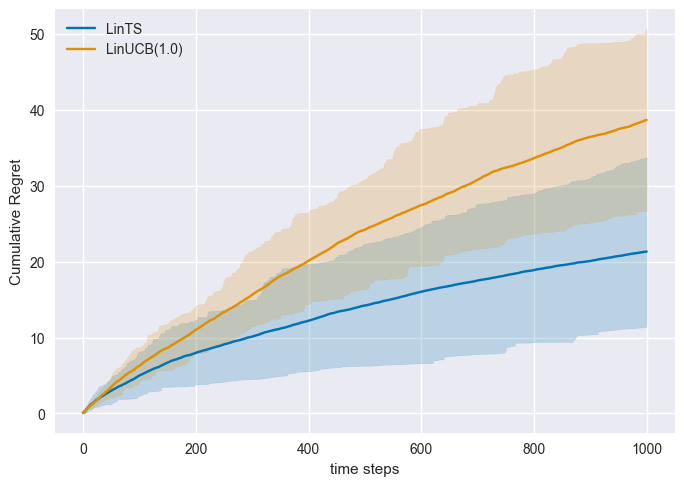

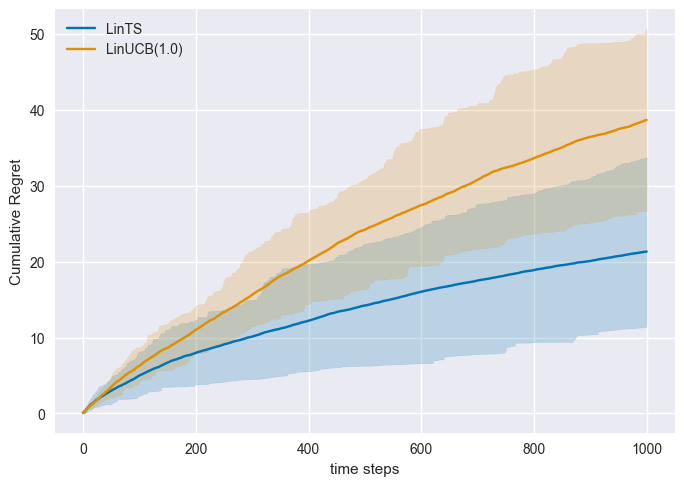

In [131]:
lints = LinTS(d, 0.2, 1.)

linucb = solutions.LinUCB(d, delta=0.2, lambda_reg=1., alpha=1.)
lin_ts_experiment = experiment_linb(lin_env, [lints, linucb], N=N, T=T)
plot_result(lin_ts_experiment)


In [132]:
# lints = LinTS(d, 0.2, 0.1)
#
# linucb = LinUCB(d, delta=0.2, lambda_reg=1., alpha=1.)
# lin_ts_experiment = experiment_linb(lin_env, [lints, linucb], N=N, T=T)
# plot_result(lin_ts_experiment)
#
# ts_regret = lin_ts_experiment['LinTS']
# cumdata = np.cumsum(ts_regret, axis=1)
# mean_reg = np.mean(cumdata, axis=0)[999]
#
# print(f"Cumulative regret for lambda - 0.1: {mean_reg}")
#
# lambdas = [0.5, 0.8, 1.0, 1.2, 2.0, 5.0,10.0, 15.0]
#
# best_regret = float("inf")
# best_params = None
# results = {}
#
#
# for lambda_reg in lambdas:
#     # Create agent with current parameter combination
#     agent = LinTS(d, 0.2, lambda_reg)
#
#     # Run experiment
#     experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)
#
#     # Compute cumulative regret
#     regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
#     mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000
#
#     # Store results
#     results[lambda_reg] = mean_regret
#
#     # Update best parameters
#     if mean_regret < best_regret:
#         best_regret = mean_regret
#         best_params = lambda_reg
#
# # Print best parameters
# print(f"Optimal lambda: {best_params}")
# print(f"Lowest cumulative regret: {best_regret}")

## Answers to Questions 2.3
- The regret for λ = 0.1 for T = 1000, average over N = 50 independent runs is roughly 35
- The lambda I found that minimizes regret is around λ = 10.

In [133]:
# lints = LinTS(d, 0.2, 10.0)
# linucb = LinUCB(d, delta=0.2, lambda_reg=10.0, alpha=0.05)
# lin_greedy = LinEpsilonGreedy(d, 5.0, 0.001)
# lin_compare_experiment = experiment_linb(lin_env, [lints, linucb, lin_greedy], N=N, T=2000)
# plot_result(lin_compare_experiment)


## Here your solution of the Assignment goes: 

## Experiments Epsilon Greedy

Cumulative regret for epsilon - 0.1: 67.3039999999999


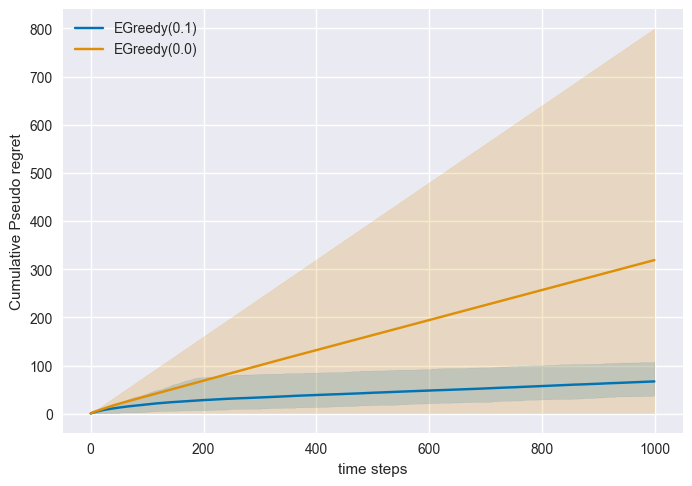

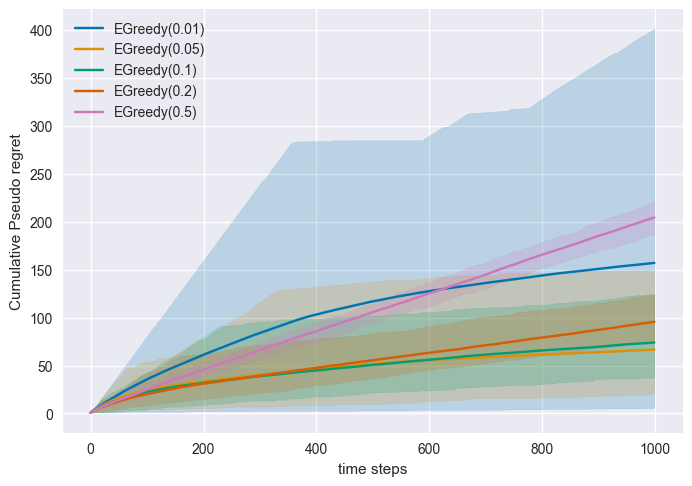

In [134]:
eps_greedy = EpsilonGreedy(K,  eps=0.1) # Pick your epsilon!

epsilons = [0.01, 0.05, 0.1, 0.2, 0.5]  # Different exploration rates
eps_greedy_tests = []
for eps in epsilons:
    eps_greedy_tests.append(EpsilonGreedy(K, eps=eps))

# epsilons_2 = [0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
# eps_greedy_tests_2 = []
#
# for eps in epsilons_2:
#     eps_greedy_tests_2.append(EpsilonGreedy(K, eps=eps))


eps_greedy_experiment = experiment_mab(env, [eps_greedy, greedy], N=N, T=T, mode="pseudo regret")
plot_result(eps_greedy_experiment, q=10, mode="pseudo regret")

eps_greedy_experiment_optimal = experiment_mab(env, eps_greedy_tests, N=N, T=T, mode="pseudo regret")
plot_result(eps_greedy_experiment_optimal, q=10, mode="pseudo regret")

# eps_greedy_experiment_optimal_2 = experiment_mab(env, eps_greedy_tests_2, N=1000, T=T, mode="pseudo regret")
# plot_result(eps_greedy_experiment_optimal_2, q=10, mode="pseudo regret")


eps_greedy_regret = eps_greedy_experiment['EGreedy(0.1)']
cumdata = np.cumsum(eps_greedy_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[999]

print(f"Cumulative regret for epsilon - 0.1: {mean_reg}")

## Answers to question 1
- The regret for ε = 0.1 for T = 1000, K = 3, average over N = 50 independent
runs is: 68.384
- The optimal value for ε that minimizes regret was found to be somewhere around 0.1 according to the results from an experiment with N=1000.
- The updated version of epsilon greedy with changing epsilon does work better. For the same run as the first question, the regret is now almost halved at 34.7

## Experiments UCB

Cumulative regret for alpha - 0.1: 79.28079999999906


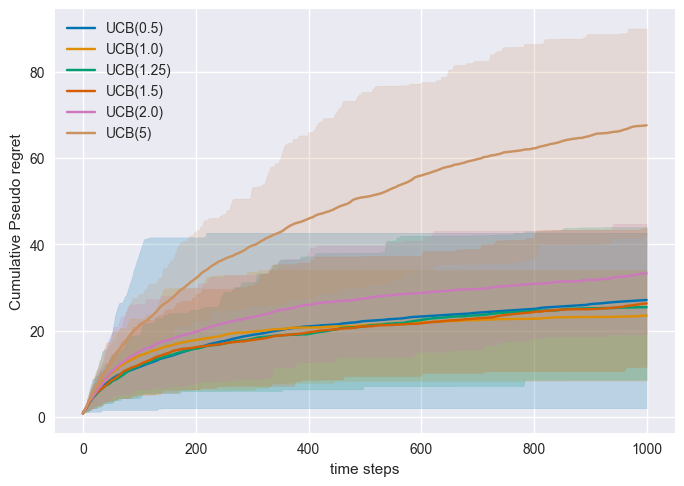

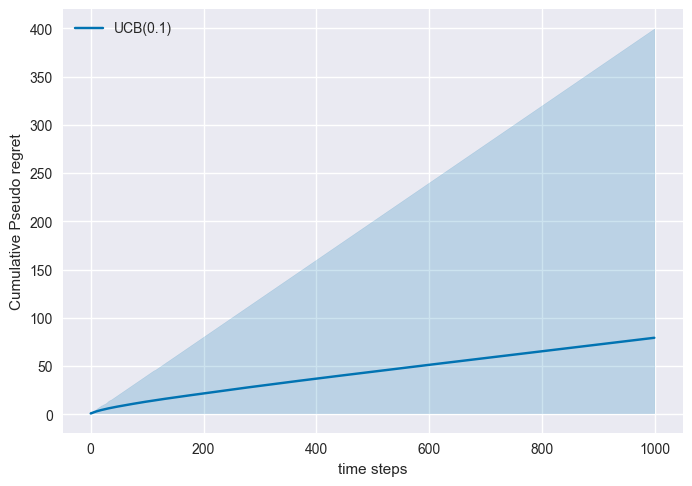

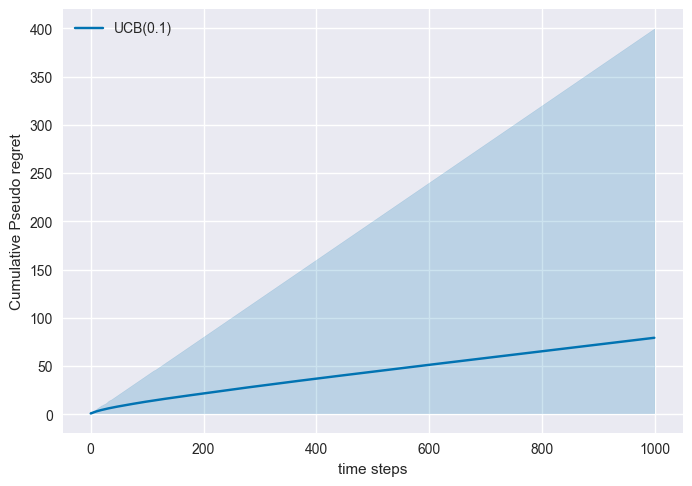

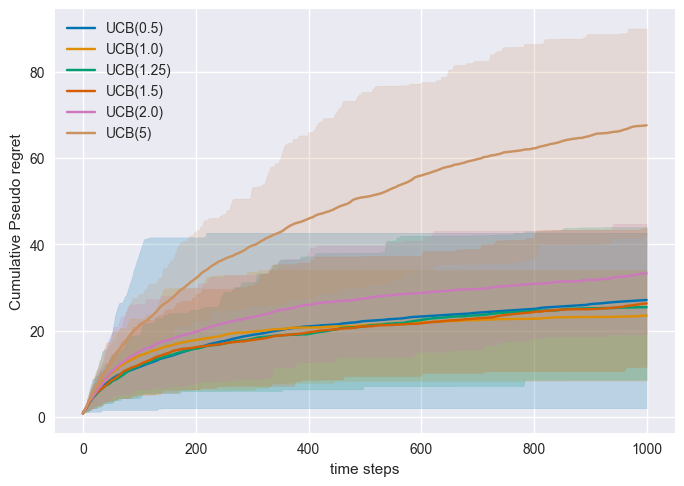

In [135]:
ucb = UCB(K, alpha=0.1) # Pick your alpha!

ucb_experiment = experiment_mab(env, [ucb], N=500, T=T, mode="pseudo regret")
plot_result(ucb_experiment, q=10, mode="pseudo regret")

ucb_regret = ucb_experiment['UCB(0.1)']
cumdata = np.cumsum(ucb_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[999]

print(f"Cumulative regret for alpha - 0.1: {mean_reg}")

alphas = [0.5, 1.0, 1.25, 1.5, 2.0, 5]
ucb_tests = []

for alpha in alphas:
    ucb_tests.append(UCB(K, alpha=alpha))

ucb_experiment_2 = experiment_mab(env, ucb_tests, N=N, T=T, mode="pseudo regret")

# Plot results
plot_result(ucb_experiment, q=10, mode="pseudo regret")
plot_result(ucb_experiment_2, q=10, mode="pseudo regret")



## Answers to question 2
- The regret for alpha = 0.1, T = 1000, K = 3, average over N = 50 independent
samples is around 80. I ran the UCB algorithm 10 times with the above specifications and the results varied quite substantially where the best runs gave a regret of around 60, but the worst runs gave a regret of 150. The runs averaged out around 100, but the variance is quite large.
- The value for alpha which minimizes the regret is around 1.0. This can be seen by plotting the experiments from the cell above. However here the variance was also quite large as any value between 0.5 and 1.5 could outperform the other values. An alpha of 1.0 performed the best most consistently.


## Experiments Thompson sampling

Cumulative regret for sigma - 1.0: 30.615999999999776


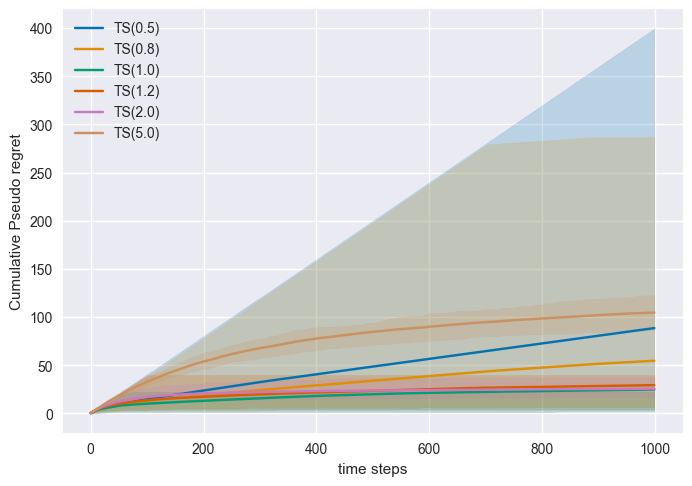

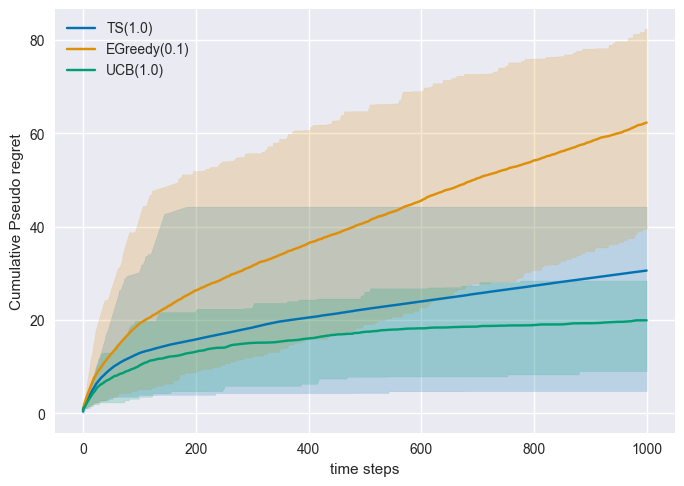

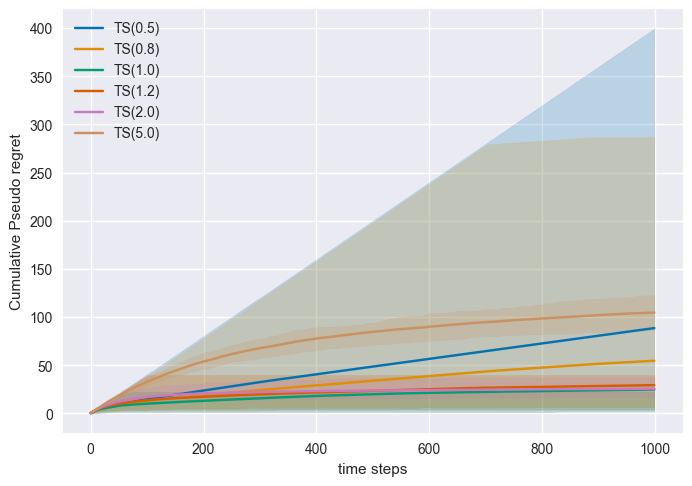

In [136]:
ts = ThompsonSampling(K)

epsilon_greedy = EpsilonGreedy(K,  eps=0.1)
ucb = UCB(K, alpha=1.0)
ts_experiment = experiment_mab(env, [ts, epsilon_greedy, ucb], N=N, T=T, mode="pseudo regret")
plot_result(ts_experiment, q=10, mode="pseudo regret")

ts_regret = ts_experiment['TS(1.0)']
cumdata = np.cumsum(ts_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[999]

print(f"Cumulative regret for sigma - 1.0: {mean_reg}")

sigmas = [0.5, 0.8, 1.0, 1.2, 2.0, 5.0]
ts_tests = []

for sigma in sigmas:
    ts_tests.append(ThompsonSampling(K, sigma=sigma))

ts_experiment_2 = experiment_mab(env, ts_tests, N=N, T=T, mode="pseudo regret")
plot_result(ts_experiment_2, q=10, mode="pseudo regret")

## Answers to question 3
- The regret for sigma = 1, T = 1000, K=3 average over N=50 independent samples is in the range of 20 to 50
- sigma = 1 also minimizes regret as that value consistently outperforms the other chosen values for sigma along 10 runs with T=1000 and N=50 to compare the values.

## Answers to question 4
As shown in the plot above The TS algorithm performs best, followed by UCB, which does slightly worse, which is again followed by epsilon greedy.

Experiments Linear Epsilon Greedy

Optimal epsilon: 0.005, Optimal lambda: 10.0
Lowest cumulative regret: 9.852437560118126
Cumulative regret for epsilon - 0.1: 19.867604868341065


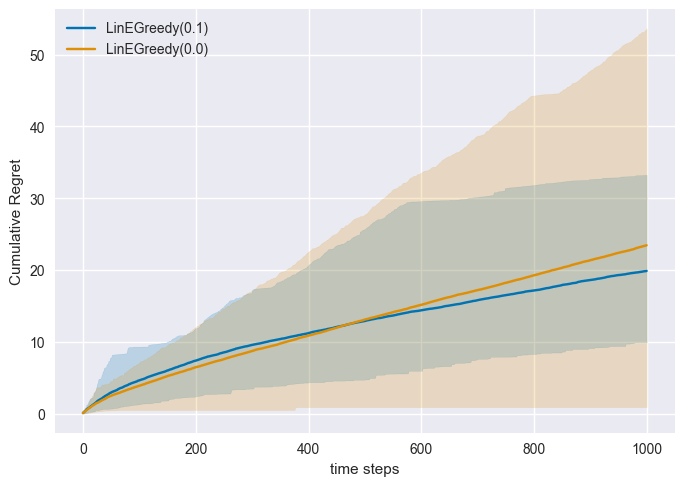

In [150]:
lin_eps_greedy = LinEpsilonGreedy(d, eps=0.1)

lin_greedy = solutions.LinEpsilonGreedy(d, eps=0.)
lin_eps_greedy_experiment = experiment_linb(lin_env, [lin_eps_greedy, lin_greedy], N=N, T=T)
plot_result(lin_eps_greedy_experiment)

eps_greedy_regret = lin_eps_greedy_experiment['LinEGreedy(0.1)']
cumdata = np.cumsum(eps_greedy_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[999]

eps_values = [0., 0.001, 0.005, 0.01, 0.1]  # Different exploration rates
lambda_values = [0.5, 1.0, 5.0, 10.0, 15.0]

eps_greedy_tests = []

best_regret = float("inf")
best_params = None
results = {}

for eps in eps_values:
    for lambda_reg in lambda_values:
        # Create agent with current parameter combination
        agent = LinEpsilonGreedy(d, eps=eps, lambda_reg=lambda_reg)

        # Run experiment
        experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)

        # Compute cumulative regret
        regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
        mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000

        # Store results
        results[(eps, lambda_reg)] = mean_regret

        # Update best parameters
        if mean_regret < best_regret:
            best_regret = mean_regret
            best_params = (eps, lambda_reg)

# Print best parameters
print(f"Optimal epsilon: {best_params[0]}, Optimal lambda: {best_params[1]}")
print(f"Lowest cumulative regret: {best_regret}")
# print(f"All results: {results}")

#
# lin_eps_greedy_experiment_2 = experiment_linb(lin_env, eps_greedy_tests, N=N, T=T)
# plot_result(lin_eps_greedy_experiment_2)


print(f"Cumulative regret for epsilon - 0.1: {mean_reg}")

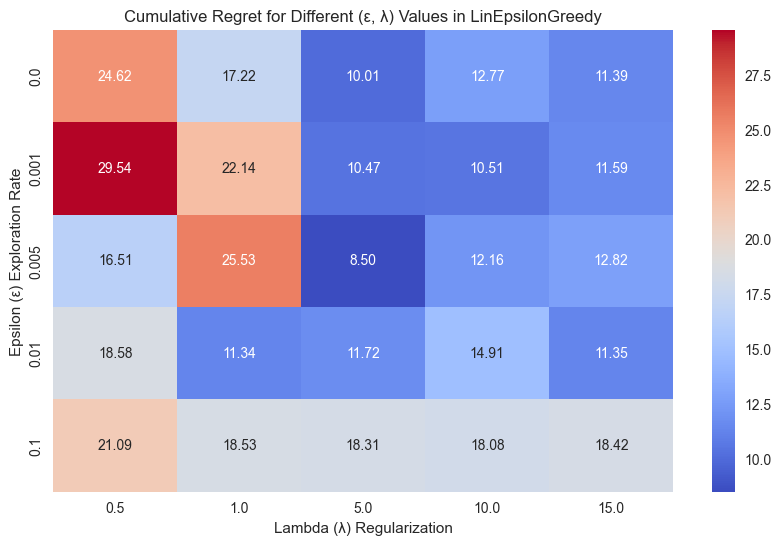

In [138]:
# Convert results dictionary into a heatmap-friendly format
eps_values_sorted = sorted(set(eps for eps, _ in results.keys()))
lambda_values_sorted = sorted(set(lmb for _, lmb in results.keys()))

heatmap_data = np.zeros((len(eps_values_sorted), len(lambda_values_sorted)))

for i, eps in enumerate(eps_values_sorted):
    for j, lambda_reg in enumerate(lambda_values_sorted):
        heatmap_data[i, j] = results[(eps, lambda_reg)]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=lambda_values_sorted, yticklabels=eps_values_sorted, cmap="coolwarm")

# Labels and title
plt.xlabel("Lambda (λ) Regularization")
plt.ylabel("Epsilon (ε) Exploration Rate")
plt.title("Cumulative Regret for Different (ε, λ) Values in LinEpsilonGreedy")
plt.show()

## Answers to 2.1
- The regret for ε = 0.1 for T = 1000, K = 3, average over N = 50 independent
runs is 55, in the cells above.
- When comparing ε = 0.0 and ε = 0.1 we see that ε = 0.0 has lower cumulative regret at timestep 1000 then ε = 0.1. This is also shown in one of the graphs where we compare the two.
- The epsilon and lambda values that gave the lowest regret seemed quite stochastic. I found that lower values for epsilon, or values between 0.0 and 0.005 seemed to the best on average. However, regret for all chosen values for epsilon were relatively close. For the lambda values the same issue arose. Different runs gave different results, but lambda = 5.0 gave the lowest results on average.

## Experiments Linear UCB

Cumulative regret for alpha - 0.1: 15.708964382149656
Optimal alphas: 0.05, Optimal lambda: 10.0
Lowest cumulative regret: 10.594951268369336


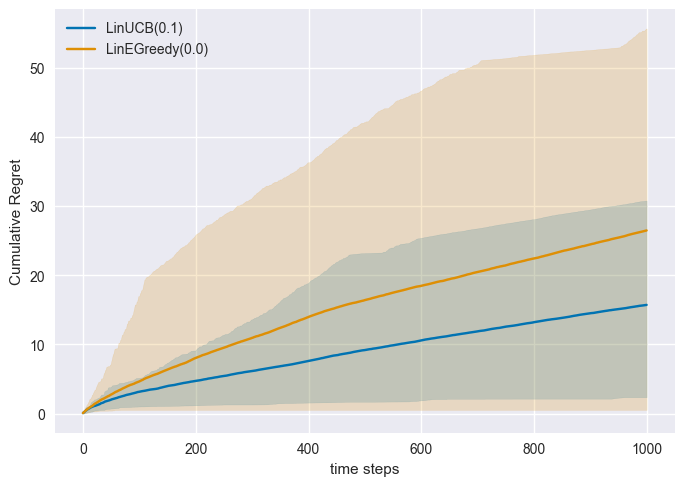

In [139]:
linucb = LinUCB(d, delta=0.2, lambda_reg=1., alpha=0.1) # You can try alpha < 1

linear_epsilon_greedy = solutions.LinEpsilonGreedy(d, eps=0.) # Greedy
lin_ucb_experiment = experiment_linb(lin_env, [linucb, linear_epsilon_greedy], N=N, T=T)
plot_result(lin_ucb_experiment)


lin_ucb_regret = lin_ucb_experiment['LinUCB(0.1)']
cumdata = np.cumsum(lin_ucb_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[999]

print(f"Cumulative regret for alpha - 0.1: {mean_reg}")


alphas = [0.05, 0.1, 0.25, 0.5, 1.0, 1.5, 2.0]
lambda_values = [0.1, 0.5, 1.0, 5.0, 10.0]

lin_ucb_tests = []

best_regret = float("inf")
best_params = None
results = {}

for alpha in alphas:
    for lambda_reg in lambda_values:
        # Create agent with current parameter combination
        agent = LinUCB(d, delta=0.2, lambda_reg=lambda_reg, alpha=alpha)

        # Run experiment
        experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)

        # Compute cumulative regret
        regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
        mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000

        # Store results
        results[(alpha, lambda_reg)] = mean_regret

        # Update best parameters
        if mean_regret < best_regret:
            best_regret = mean_regret
            best_params = (alpha, lambda_reg)

# Print best parameters
print(f"Optimal alphas: {best_params[0]}, Optimal lambda: {best_params[1]}")
print(f"Lowest cumulative regret: {best_regret}")


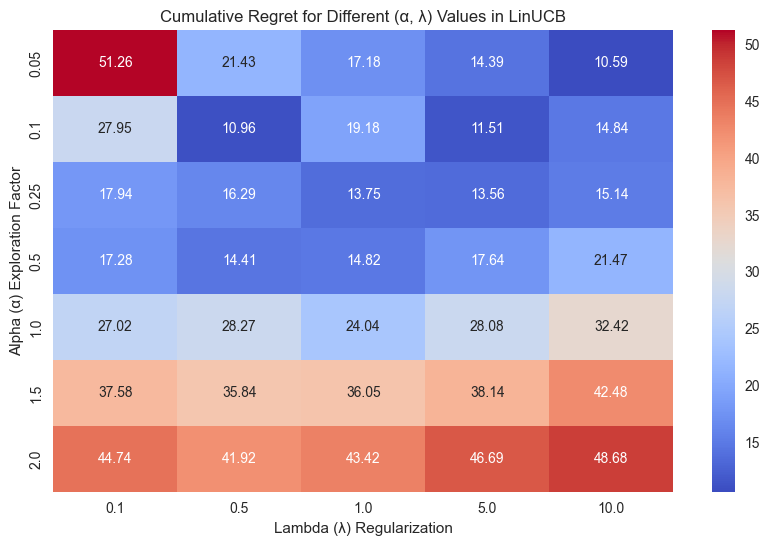

In [140]:
# Convert results dictionary into a heatmap-friendly format
alpha_values_sorted = sorted(set(alpha for alpha, _ in results.keys()))
lambda_values_sorted = sorted(set(lmb for _, lmb in results.keys()))

heatmap_data = np.zeros((len(alpha_values_sorted), len(lambda_values_sorted)))

for i, alpha in enumerate(alpha_values_sorted):
    for j, lambda_reg in enumerate(lambda_values_sorted):
        heatmap_data[i, j] = results[(alpha, lambda_reg)]

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=lambda_values_sorted, yticklabels=alpha_values_sorted, cmap="coolwarm")

# Labels and title
plt.xlabel("Lambda (λ) Regularization")
plt.ylabel("Alpha (α) Exploration Factor")
plt.title("Cumulative Regret for Different (α, λ) Values in LinUCB")
plt.show()

In [141]:
d_values = [2, 4, 8, 16, 50, 100]
K_values = [3, 5, 10]
n_contexts_values = [2, 5, 10]

final_regrets = []

for d_v in d_values:
    theta_test = np.random.normal(0., 1., size=d_v)
    theta_test = theta_test / np.linalg.norm(theta_test)
    for k_v in K_values:
        for n_v in n_contexts_values:
            lin_env_tests = LinearBandit(theta_test, k_v, n_v)
            lin_ucb_test = LinUCB(d_v, delta=0.2, lambda_reg=1., alpha=0.1)
            lin_ucb_experiment_2 = experiment_linb(lin_env_tests, [lin_ucb_test], N=N, T=T)

            regret_data = np.cumsum(lin_ucb_experiment_2[lin_ucb_test.name()], axis=1)
            mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000
            final_regrets.append(mean_regret)
            print(f'Regret for linear UCB at d={d_v}, K={k_v}, N={n_v}, Final regret: {mean_regret}')


Regret for linear UCB at d=2, K=3, N=2, Final regret: 3.7010242717204704
Regret for linear UCB at d=2, K=3, N=5, Final regret: 8.400484167506795
Regret for linear UCB at d=2, K=3, N=10, Final regret: 3.9690236923334
Regret for linear UCB at d=2, K=5, N=2, Final regret: 49.07912173082218
Regret for linear UCB at d=2, K=5, N=5, Final regret: 7.082916251216266
Regret for linear UCB at d=2, K=5, N=10, Final regret: 11.77501178080699
Regret for linear UCB at d=2, K=10, N=2, Final regret: 14.815138506235206
Regret for linear UCB at d=2, K=10, N=5, Final regret: 26.184080690079995
Regret for linear UCB at d=2, K=10, N=10, Final regret: 21.764342901237306
Regret for linear UCB at d=4, K=3, N=2, Final regret: 7.416583323344512
Regret for linear UCB at d=4, K=3, N=5, Final regret: 25.297554317001055
Regret for linear UCB at d=4, K=3, N=10, Final regret: 19.356119834796335
Regret for linear UCB at d=4, K=5, N=2, Final regret: 73.48507784519313
Regret for linear UCB at d=4, K=5, N=5, Final regret:

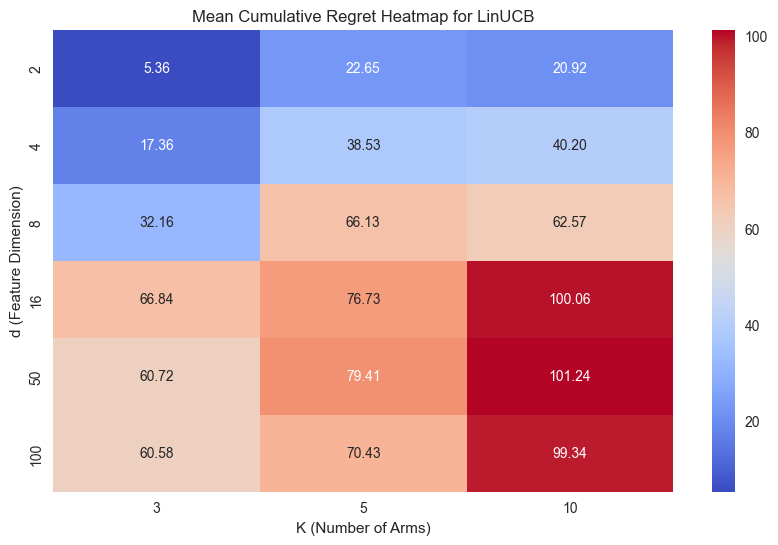

In [142]:
# Convert data into a DataFrame for better visualization
data = []
index = 0

for d_v in d_values:
    for k_v in K_values:
        for n_v in n_contexts_values:
            data.append([d_v, k_v, n_v, final_regrets[index]])
            index += 1

df = pd.DataFrame(data, columns=['d', 'K', 'N', 'Regret'])

# Heatmap of regret for different (d, K) values averaged over N
plt.figure(figsize=(10, 6))
pivot_df = df.pivot_table(values='Regret', index='d', columns='K', aggfunc='mean')
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.xlabel("K (Number of Arms)")
plt.ylabel("d (Feature Dimension)")
plt.title("Mean Cumulative Regret Heatmap for LinUCB")
plt.show()

## Answers to question 2.2
- The regret for α = 0.1, λ = 0.1 for T = 1000, average over N = 50 independent runs is around 15
- The alpha and lambda values to minimize regret I found quite stochastic. Every alpha value below 0.5 seemed to perform very similar. Values above 0.5 did perform worse. For lambda the optimal values also seemed quite stochastic, however for the lower alpha values, higher lambda values seemed to perform slightly better, if I compared different runs. A relatively low value for alpha and a relatively high value for lambda indicate that in this model less exploration is better. As there are only 3 arms, finding the optimal arm relatively fast is possible. These values cause lower rates of explorations, but therefore a possible faster convergence.
- In the graph above we see that for smaller dimensions the regret is relatively lower. This is because in higher dimensions the potential reward is greater, as the reward is calculated with the dot product of higher dimensional vectors. With higher potential rewards, we also get higher potential regret, as the cost of taking an exploring or bad action is higher.

## Experiments Linear Thompson Sampling

Cumulative regret for lambda - 0.1: 41.218667129725475
Optimal lambda: 1.0
Lowest cumulative regret: 21.177420069469587


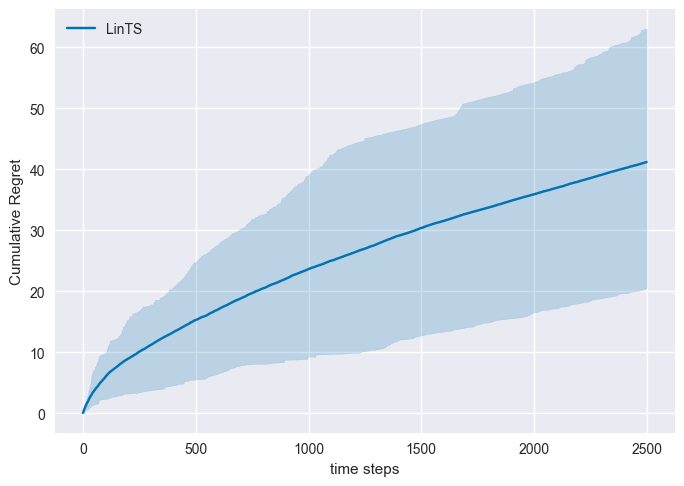

In [143]:
lints = LinTS(d, 0.2, 0.1)

linucb = LinUCB(d, delta=0.2, lambda_reg=1., alpha=1.)
lin_ts_experiment = experiment_linb(lin_env, [lints], N=N, T=2500)
plot_result(lin_ts_experiment)

ts_regret = lin_ts_experiment['LinTS']
cumdata = np.cumsum(ts_regret, axis=1)
mean_reg = np.mean(cumdata, axis=0)[2499]

print(f"Cumulative regret for lambda - 0.1: {mean_reg}")

lambdas = [0.5, 0.8, 1.0, 1.2, 2.0, 5.0,10.0, 15.0]

best_regret = float("inf")
best_params = None
results = {}


for lambda_reg in lambdas:
    # Create agent with current parameter combination
    agent = LinTS(d, 0.2, lambda_reg)

    # Run experiment
    experiment_results = experiment_linb(lin_env, [agent], N=N, T=T)

    # Compute cumulative regret
    regret_data = np.cumsum(experiment_results[agent.name()], axis=1)
    mean_regret = np.mean(regret_data, axis=0)[999]  # Regret at T=1000

    # Store results
    results[lambda_reg] = mean_regret

    # Update best parameters
    if mean_regret < best_regret:
        best_regret = mean_regret
        best_params = lambda_reg

# Print best parameters
print(f"Optimal lambda: {best_params}")
print(f"Lowest cumulative regret: {best_regret}")

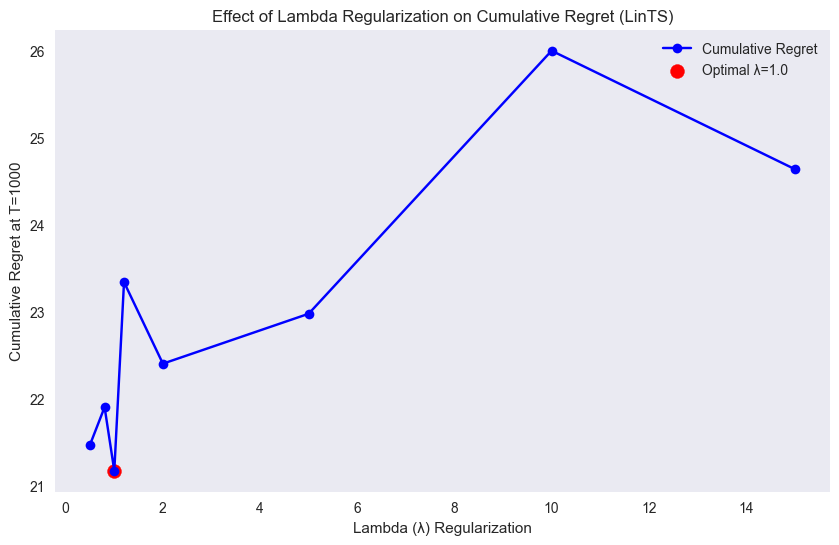

In [144]:
# Sort results for better visualization
sorted_lambdas = sorted(results.keys())
sorted_regrets = [results[lambda_reg] for lambda_reg in sorted_lambdas]

# Plot lambda vs. regret
plt.figure(figsize=(10, 6))
plt.plot(sorted_lambdas, sorted_regrets, marker='o', linestyle='-', color='b', label="Cumulative Regret")

# Highlight the best lambda
plt.scatter(best_params, best_regret, color='red', s=100, label=f"Optimal λ={best_params}")

# Labels and title
plt.xlabel("Lambda (λ) Regularization")
plt.ylabel("Cumulative Regret at T=1000")
plt.title("Effect of Lambda Regularization on Cumulative Regret (LinTS)")
plt.legend()
plt.grid()
plt.show()

## Answers to Questions 2.3
- The regret for λ = 0.1 for T = 1000, average over N = 50 independent runs is roughly 35 with an error margin of 15 due to the stochastic nature of Thompson sampling
- The lambda I found that minimizes regret is somewhere between 1.0 and 15.0. As shown in the graph above, the optimal values seem very stochastic and for between runs different lambda values can return optimal. Very low values of lambda however did not return the optimal scores.

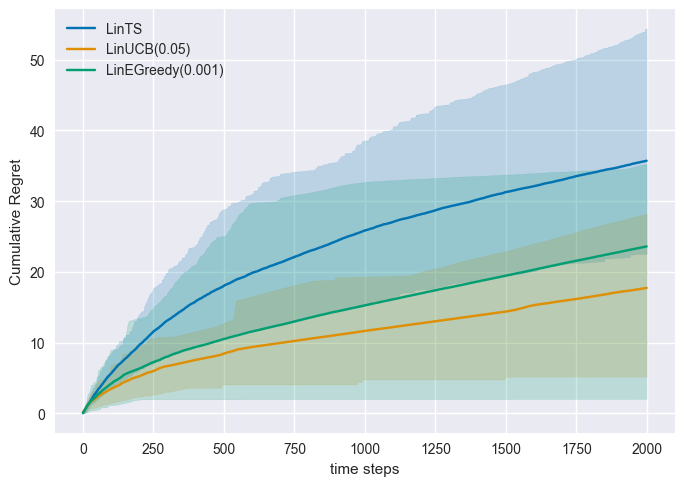

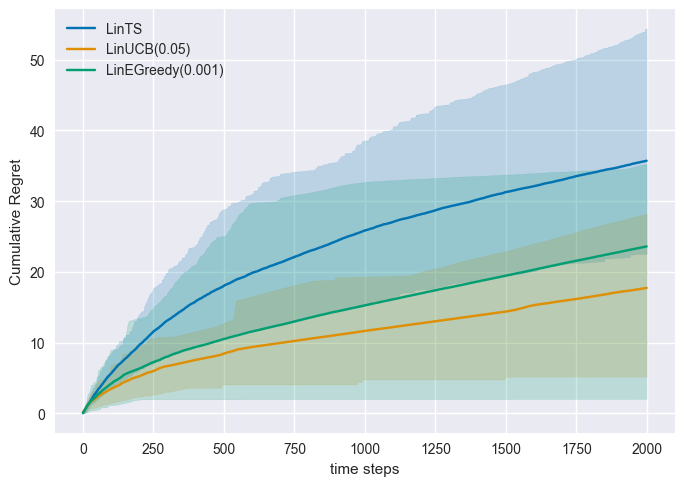

In [145]:
lints = LinTS(d, 0.2, 10.0)
linucb = LinUCB(d, delta=0.2, lambda_reg=10.0, alpha=0.05)
lin_greedy = LinEpsilonGreedy(d, 5.0, 0.001)
lin_compare_experiment = experiment_linb(lin_env, [lints, linucb, lin_greedy], N=N, T=2000)
plot_result(lin_compare_experiment)


## Answer to Question 2.4
As shown in the plot above, epsilon greedy with the optimal values I found performs the best, followed by Linear UCB followed by Linear thompson sampling. This is likely due to the low number of arms in the model. Both UCB and epsilon greedy, which have very similar results, will converge to a best arm very quickly. As there are only three arms in this experiment it is unlikely they will get stuck in local minima, but instead find the optimal arms first. Linear Thompson Sampling, samples from a random distribution, and thus invite more stochasticity and takes long to converge.